In [2]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score


In [3]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

# Calculate the mean flowrate over the past week / month
df['mean_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).mean()
df['mean_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).mean()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).mean()

scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_week']] = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_week']])
scaler_flow = StandardScaler()
df[['flowrate']] = scaler_flow.fit_transform(df[['flowrate']])
scaler_statflow = StandardScaler()
df[['min_flow_week','min_flow_month','mean_flow_week','mean_flow_month']] = scaler_statflow.fit_transform(df[['min_flow_week','min_flow_month','mean_flow_week','mean_flow_month']])

In [4]:
## encode datetime ##

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# encode cyclical features
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [5]:
df.describe()

,rainfall,flowrate,min_flow_week,min_flow_month,mean_flow_week,mean_flow_month,rainfall_lag1,rainfall_lag2,rainfall_lag3,rainfall_week,year,month,day,day_of_week,day_of_year,week_of_year,day_of_week_sin,day_of_week_cos
count,4.693000e+03,4.693000e+03,4.693000e+03,4.693000e+03,4.693000e+03,4.693000e+03,4.692000e+03,4.691000e+03,4.690000e+03,4.693000e+03,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000
mean,5.147763e-17,-9.992717e-17,9.689907e-17,-1.090115e-16,7.267430e-17,1.514048e-16,-5.451735e-17,-7.119060e-17,5.151056e-17,9.084288e-17,2015.530151,6.604304,15.646708,3.004688,185.512465,26.871724,-0.002319,0.000127
std,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,4.122149,3.346634,8.812848,2.001699,102.276153,14.598409,0.707479,0.706882
min,-4.130685e-01,-1.006312e+00,-1.003426e+00,-9.790854e-01,-1.011414e+00,-1.037214e+00,-4.131200e-01,-4.131716e-01,-4.131653e-01,-7.403805e-01,2007.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-0.974928,-0.900969
25%,-4.130685e-01,-7.344459e-01,-7.253982e-01,-6.652498e-01,-7.392128e-01,-7.715992e-01,-4.131200e-01,-4.131716e-01,-4.131653e-01,-7.403805e-01,2012.000000,4.000000,8.000000,1.000000,99.000000,14.000000,-0.781831,-0.900969
50%,-4.130685e-01,-5.080155e-01,-4.936505e-01,-4.632525e-01,-5.089076e-01,-4.809306e-01,-4.131200e-01,-4.131716e-01,-4.131653e-01,-5.509488e-01,2015.000000,7.000000,16.000000,3.000000,189.000000,27.000000,0.000000,-0.222521
75%,-1.103875e-01,5.516795e-01,4.977898e-01,4.047674e-01,5.558024e-01,6.410596e-01,-1.104658e-01,-1.105441e-01,-1.105691e-01,5.339786e-01,2019.000000,9.000000,23.000000,5.000000,272.000000,39.000000,0.781831,0.623490
max,9.703202e+00,3.897269e+00,4.036488e+00,4.263678e+00,3.697739e+00,3.258070e+00,9.702257e+00,9.701311e+00,9.700271e+00,4.890909e+00,2024.000000,12.000000,31.000000,6.000000,366.000000,53.000000,0.974928,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4693 entries, 2007-03-07 00:00:00+00:00 to 2024-05-06 00:00:00+00:00
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rainfall         4693 non-null   float64
 1   flowrate         4693 non-null   float64
 2   min_flow_week    4693 non-null   float64
 3   min_flow_month   4693 non-null   float64
 4   mean_flow_week   4693 non-null   float64
 5   mean_flow_month  4693 non-null   float64
 6   rainfall_lag1    4692 non-null   float64
 7   rainfall_lag2    4691 non-null   float64
 8   rainfall_lag3    4690 non-null   float64
 9   rainfall_week    4693 non-null   float64
 10  year             4693 non-null   int64  
 11  month            4693 non-null   int64  
 12  day              4693 non-null   int64  
 13  day_of_week      4693 non-null   int64  
 14  day_of_year      4693 non-null   int64  
 15  week_of_year     4693 non-null   int32  
 16  day_of_week_

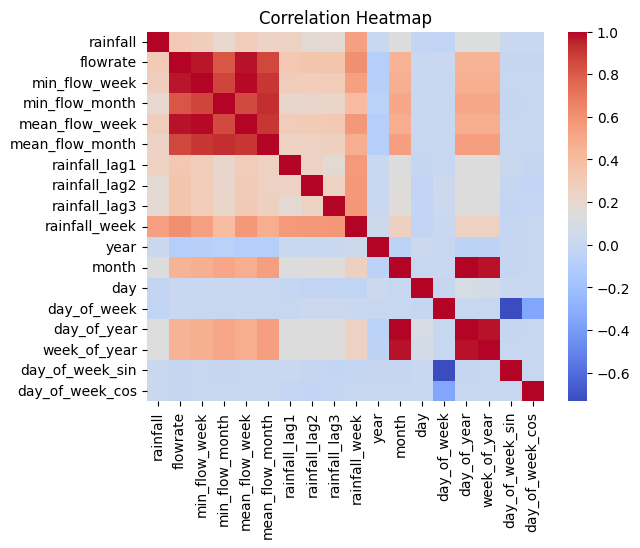

Index(['rainfall', 'flowrate', 'min_flow_week', 'min_flow_month',
       'mean_flow_week', 'mean_flow_month', 'rainfall_lag1', 'rainfall_lag2',
       'rainfall_lag3', 'rainfall_week', 'year', 'month', 'day', 'day_of_week',
       'day_of_year', 'week_of_year', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')

In [7]:
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
df.columns

In [8]:
# drop non-needed columns
df = df.drop(columns=['year', 'day', 'day_of_week', 'day_of_year', 'day_of_week_sin', 'day_of_week_cos'])

In [9]:
# drop rows with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4690 entries, 2007-04-16 00:00:00+00:00 to 2024-05-06 00:00:00+00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rainfall         4690 non-null   float64
 1   flowrate         4690 non-null   float64
 2   min_flow_week    4690 non-null   float64
 3   min_flow_month   4690 non-null   float64
 4   mean_flow_week   4690 non-null   float64
 5   mean_flow_month  4690 non-null   float64
 6   rainfall_lag1    4690 non-null   float64
 7   rainfall_lag2    4690 non-null   float64
 8   rainfall_lag3    4690 non-null   float64
 9   rainfall_week    4690 non-null   float64
 10  month            4690 non-null   int64  
 11  week_of_year     4690 non-null   int32  
dtypes: float64(10), int32(1), int64(1)
memory usage: 458.0 KB


<Axes: >

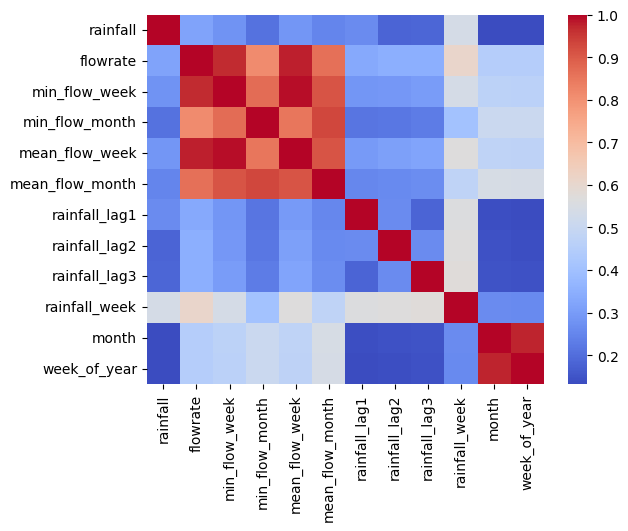

In [10]:
sns.heatmap(df.corr(), cmap='coolwarm')

In [11]:
## all rainfall lag & weekly and monthly base flowrate ##

X = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_week', 'min_flow_week', 'min_flow_month']]
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

lr_model = LinearRegression()

# Perform 5-fold cross-validation
cv_scores_mse = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(lr_model, X, y, cv=5, scoring='r2')

mean_cv_mse = -cv_scores_mse.mean()
mean_cv_r2 = cv_scores_r2.mean()
print("Linear Regression Model (all data included)")
print("\nCross-Validation Results (5-fold)")
print("Mean Squared Error:", mean_cv_mse)
print("R-squared:", mean_cv_r2)

lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print("\nMean Squared Error:", lr_mse)
print("R-squared:", lr_r2)

Linear Regression Model (all data included)

Cross-Validation Results (5-fold)
Mean Squared Error: 0.05005051586276175
R-squared: 0.9476787819532699

Mean Squared Error: 0.05902261200052233
R-squared: 0.9469564824145056


In [12]:
# Lasso Hyperparameter Tuning
lasso_params = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

best_lasso_model = lasso_grid.best_estimator_
lasso_pred = best_lasso_model.predict(X_test)

lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print("Best Lasso alpha:", lasso_grid.best_params_)
print("Best Lasso Cross-Validated MSE:", -lasso_grid.best_score_)
print("Lasso Regression Model")
print("Mean Squared Error on Test Set:", lasso_mse)
print("R-squared on Test Set:", lasso_r2)

# Ridge Hyperparameter Tuning
ridge_params = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

best_ridge_model = ridge_grid.best_estimator_
ridge_pred = best_ridge_model.predict(X_test)

ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print("\nBest Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge Cross-Validated MSE:", -ridge_grid.best_score_)
print("Ridge Regression Model")
print("Mean Squared Error on Test Set:", ridge_mse)
print("R-squared on Test Set:", ridge_r2)

Best Lasso alpha: {'alpha': 0.0001}
Best Lasso Cross-Validated MSE: 0.04712459218512572
Lasso Regression Model
Mean Squared Error on Test Set: 0.0590262284569847
R-squared on Test Set: 0.9469532323114441

Best Ridge alpha: {'alpha': 0.0001}
Best Ridge Cross-Validated MSE: 0.047121039740381364
Ridge Regression Model
Mean Squared Error on Test Set: 0.0590226123336133
R-squared on Test Set: 0.9469564821151574


In [13]:
## Polynomial and interaction features (all data) ##

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Train-test split with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

sorted_train_indices = np.argsort(y_train.index)
sorted_test_indices = np.argsort(y_test.index)

X_train_poly = X_train_poly[sorted_train_indices]
y_train = y_train.iloc[sorted_train_indices].values
X_test_poly = X_test_poly[sorted_test_indices]
y_test = y_test.iloc[sorted_test_indices].values

# Linear Regression with polynomial features
lr_poly_model = LinearRegression()
lr_poly_model.fit(X_train_poly, y_train)
lr_poly_pred = lr_poly_model.predict(X_test_poly)

lr_poly_mse = mean_squared_error(y_test, lr_poly_pred)
lr_poly_r2 = r2_score(y_test, lr_poly_pred)

print("Linear Regression Model with Polynomial Features")
print("Mean Squared Error on Test Set:", lr_poly_mse)
print("R-squared on Test Set:", lr_poly_r2)

# reverse scaling
y_test = scaler_flow.inverse_transform(y_test.reshape(-1, 1))
lr_poly_pred = scaler_flow.inverse_transform(lr_pred.reshape(-1, 1))

# Extract coefficients
coefficients = lr_poly_model.coef_
intercept = lr_poly_model.intercept_

# Get feature names
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Display polynomial equation
equation = f"{intercept}"
for coef, name in zip(coefficients, feature_names):
    equation += f" + ({coef} * {name})"

print("Polynomial Regression Equation:")
print(equation)

Linear Regression Model with Polynomial Features
Mean Squared Error on Test Set: 0.053682637994674834
R-squared on Test Set: 0.9517555076606731
Polynomial Regression Equation:
0.1179072523116111 + (0.011292777307302007 * rainfall) + (0.0002538700270532084 * week_of_year) + (0.014811650783580857 * rainfall_lag1) + (0.02362367136468829 * rainfall_lag2) + (0.01721571059964694 * rainfall_lag3) + (0.030468384835597044 * rainfall_week) + (1.2191587710555407 * min_flow_week) + (-0.07922478290330993 * min_flow_month) + (-0.004918569206637357 * rainfall^2) + (-0.000528401729249326 * rainfall week_of_year) + (-0.009625724940202354 * rainfall rainfall_lag1) + (-0.008919335464069266 * rainfall rainfall_lag2) + (-0.015180259645940605 * rainfall rainfall_lag3) + (0.024691529631996785 * rainfall rainfall_week) + (-0.012063252314129467 * rainfall min_flow_week) + (0.022645481613287218 * rainfall min_flow_month) + (-5.4598685281845756e-05 * week_of_year^2) + (0.00043191116402527713 * week_of_year rainf

In [107]:
## all rainfall lag & weekly baseline flowrate ##

X2 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_week', 'min_flow_week']]
y2 = df['flowrate']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train2 = X_train2.sort_index()
y_train2 = y_train2.sort_index()
X_test2 = X_test2.sort_index()
y_test2 = y_test2.sort_index()

lr_model2 = LinearRegression()
lr_model2.fit(X_train2, y_train2)
lr_pred2 = lr_model2.predict(X_test2)

lr_mse2 = mean_squared_error(y_test2, lr_pred2)
lr_r22 = r2_score(y_test2, lr_pred2)

print("Linear Regression Model (Weekly Baseline Flowrate)")
print("Mean Squared Error:", lr_mse2)
print("R-squared:", lr_r22)

Linear Regression Model (Weekly Baseline Flowrate)
Mean Squared Error: 0.062057080548363695
R-squared: 0.9442294108681188


In [108]:
## all rainfall lag & monthly baseline flowrate ##

X3 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_week', 'min_flow_month']]
y3 = df['flowrate']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_train3 = X_train3.sort_index()
y_train3 = y_train3.sort_index()
X_test3 = X_test3.sort_index()
y_test3 = y_test3.sort_index()

lr_model3 = LinearRegression()
lr_model3.fit(X_train3, y_train3)
lr_pred3 = lr_model3.predict(X_test3)

lr_mse3 = mean_squared_error(y_test3, lr_pred3)
lr_r23 = r2_score(y_test3, lr_pred3)

print("Linear Regression Model (Monthly Baseline Flowrate)")
print("Mean Squared Error:", lr_mse3)
print("R-squared:", lr_r23)

Linear Regression Model (Monthly Baseline Flowrate)
Mean Squared Error: 0.2897383329424027
R-squared: 0.7396126698275203


In [109]:
## week rainfall mean & weekly baseline flowrate ##

X4 = df[['rainfall_week', 'week_of_year', 'rainfall', 'min_flow_week']]
y4 = df['flowrate']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)
X_train4 = X_train4.sort_index()
y_train4 = y_train4.sort_index()
X_test4 = X_test4.sort_index()
y_test4 = y_test4.sort_index()

lr_model4 = LinearRegression()
lr_model4.fit(X_train4, y_train4)
lr_pred4 = lr_model4.predict(X_test4)

lr_mse4 = mean_squared_error(y_test4, lr_pred4)
lr_r24 = r2_score(y_test4, lr_pred4)

print("Linear Regression Model (Rainfall Mean & Weekly Baseline Flowrate)")
print("Mean Squared Error:", lr_mse4)
print("R-squared:", lr_r24)

Linear Regression Model (Rainfall Mean & Weekly Baseline Flowrate)
Mean Squared Error: 0.06276848249310657
R-squared: 0.9435900751917176


In [110]:
## week rainfall mean & monthly baseline flowrate ##
X5 = df[['rainfall_week', 'week_of_year', 'rainfall', 'min_flow_month']]
y5 = df['flowrate']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)
X_train5 = X_train5.sort_index()
y_train5 = y_train5.sort_index()
X_test5 = X_test5.sort_index()
y_test5 = y_test5.sort_index()

lr_model5 = LinearRegression()
lr_model5.fit(X_train5, y_train5)
lr_pred5 = lr_model5.predict(X_test5)

lr_mse5 = mean_squared_error(y_test5, lr_pred5)
lr_r25 = r2_score(y_test5, lr_pred5)

print("Linear Regression Model (Rainfall Mean & Monthly Baseline Flowrate)")
print("Mean Squared Error:", lr_mse5)
print("R-squared:", lr_r25)

Linear Regression Model (Rainfall Mean & Monthly Baseline Flowrate)
Mean Squared Error: 0.2895786638791563
R-squared: 0.7397561641338057


In [111]:
## dataframe to store results ##
results = pd.DataFrame(columns=['Linear Reg Model', 'Mean Squared Error', 'R-squared'])
results.loc[0] = ['All Data', lr_mse, lr_r2]
results.loc[1] = ['Weekly Baseline (Rainfall lags)', lr_mse2, lr_r22]
results.loc[2] = ['Monthly Baseline (Rainfall lag)', lr_mse3, lr_r23]
results.loc[3] = ['Weekly Baseline (Weekly Rainfall)', lr_mse4, lr_r24]
results.loc[4] = ['Monthly Baseline (Weekly Rainfall)', lr_mse5, lr_r25]
results.loc[5] = ['Lasso (All Data)', lasso_mse, lasso_r2]
results.loc[6] = ['Ridge (All Data)', ridge_mse, ridge_r2]
results.loc[7] = ['Poly Features (All Data)', lr_poly_mse, lr_poly_r2]
results = results.sort_values(by='Mean Squared Error')
results

,Linear Reg Model,Mean Squared Error,R-squared
7,Poly Features (All Data),0.053683,0.951756
0,All Data,0.059023,0.946956
6,Ridge (All Data),0.059023,0.946956
5,Lasso (All Data),0.059026,0.946953
1,Weekly Baseline (Rainfall lags),0.062057,0.944229
3,Weekly Baseline (Weekly Rainfall),0.062768,0.943590
4,Monthly Baseline (Weekly Rainfall),0.289579,0.739756
2,Monthly Baseline (Rainfall lag),0.289738,0.739613


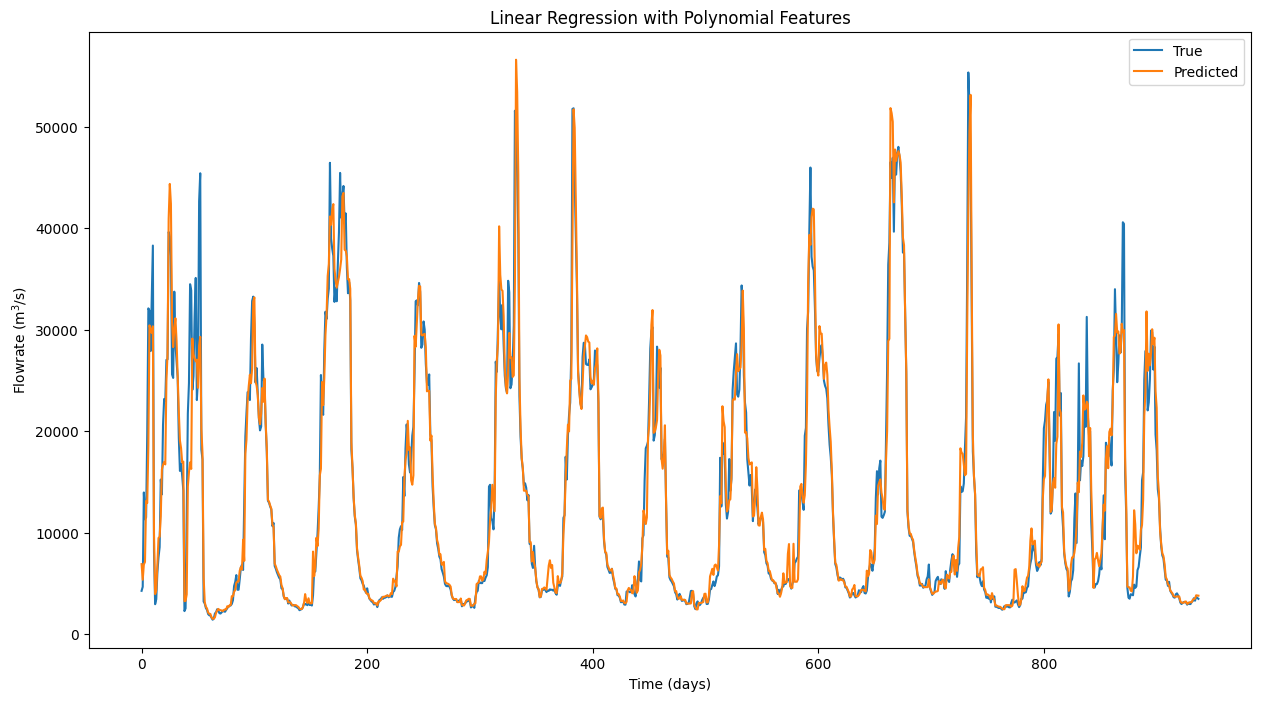

In [118]:
## Plot the best model: poly features ##

plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(lr_poly_pred, label='Predicted')
plt.title('Linear Regression with Polynomial Features')
plt.xlabel('Time (days)')
plt.ylabel('Flowrate (m$^3$/s)')
plt.legend()
plt.show()